<a href="https://colab.research.google.com/github/AAA123404/Financial-big-data-analysis/blob/main/week7%E4%BD%9C%E6%A5%AD_%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-10-30 10:59:44--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.195.138, 74.125.195.113, 74.125.195.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-10-30 10:59:44--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.195.132, 2607:f8b0:400e:c0a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M   102MB/s    in 0.2s    

2024-10-30 10:59:

In [2]:
!pip install yfinance pandas numpy torch scikit-learn matplotlib

In [3]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.3 MB/s eta 0:00:00


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [5]:
def download_data(stock_symbol, start_date, end_date):
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    return data

def generate_labels(data, short_window=5, long_window=10):
    data['MA5'] = data['Close'].rolling(window=short_window).mean()
    data['MA10'] = data['Close'].rolling(window=long_window).mean()
    data['Label'] = np.where(data['MA5'] > data['MA10'], 1, 0)  # MA5 > MA10 標註為 1 (漲)，否則為 0 (跌)
    data = data.dropna()
    return data

In [6]:
class StockDataset(Dataset):
    def __init__(self, data, labels, window_size=20):
        self.data = data
        self.labels = labels
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx:idx + self.window_size]
        x = torch.FloatTensor(window).permute(1, 0)
        x = x.unsqueeze(0)
        y = torch.LongTensor([self.labels[idx + self.window_size]])
        return x, y

In [7]:
class StockCNN(nn.Module):
    def __init__(self, input_height, input_width):
        super(StockCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        h_out = input_height // 4
        w_out = input_width // 4
        self.fc1 = nn.Linear(64 * h_out * w_out, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [8]:
stock_symbol = "2330.TW"
start_date = "2020-01-01"
end_date = "2024-01-01"
data = download_data(stock_symbol, start_date, end_date)
data = generate_labels(data)

scaler = MinMaxScaler()
features = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled_data = scaler.fit_transform(data[features])
labels = data['Label'].values


[*********************100%***********************]  1 of 1 completed


In [9]:
window_size = 30
dataset = StockDataset(scaled_data, labels, window_size=window_size)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            labels = labels.squeeze().long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [11]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.squeeze().long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.tolist())
            all_preds.extend(predicted.tolist())

    avg_loss = test_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=['跌', '漲']))

    # 混淆矩陣
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['跌', '漲'], yticklabels=['跌', '漲'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Epoch [1/50], Loss: 0.6967
Epoch [2/50], Loss: 0.6885
Epoch [3/50], Loss: 0.6870
Epoch [4/50], Loss: 0.6884
Epoch [5/50], Loss: 0.6826
Epoch [6/50], Loss: 0.6869
Epoch [7/50], Loss: 0.6754
Epoch [8/50], Loss: 0.6617
Epoch [9/50], Loss: 0.6522
Epoch [10/50], Loss: 0.6359
Epoch [11/50], Loss: 0.5921
Epoch [12/50], Loss: 0.5447
Epoch [13/50], Loss: 0.4751
Epoch [14/50], Loss: 0.4120
Epoch [15/50], Loss: 0.4028
Epoch [16/50], Loss: 0.3683
Epoch [17/50], Loss: 0.3315
Epoch [18/50], Loss: 0.2907
Epoch [19/50], Loss: 0.2784
Epoch [20/50], Loss: 0.2732
Epoch [21/50], Loss: 0.2805
Epoch [22/50], Loss: 0.3188
Epoch [23/50], Loss: 0.3078
Epoch [24/50], Loss: 0.2753
Epoch [25/50], Loss: 0.2463
Epoch [26/50], Loss: 0.2301
Epoch [27/50], Loss: 0.2252
Epoch [28/50], Loss: 0.2085
Epoch [29/50], Loss: 0.2211
Epoch [30/50], Loss: 0.2285
Epoch [31/50], Loss: 0.1940
Epoch [32/50], Loss: 0.1941
Epoch [33/50], Loss: 0.2027
Epoch [34/50], Loss: 0.2411
Epoch [35/50], Loss: 0.1880
Epoch [36/50], Loss: 0.1756
E

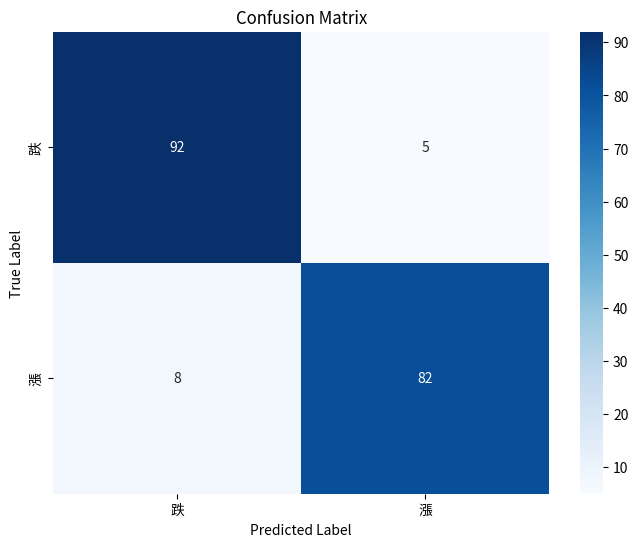

In [12]:
model = StockCNN(input_height=5, input_width=window_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer)

test_model(model, test_loader, criterion)